This script creates JRA55-do scaling files with Nino 3.4 index anomaly time series in them.

The perturbations are done using the libaccessom2 perturbations code, see the tutorial here https://github.com/COSIMA/access-om2/wiki/Tutorials#Scaling-the-forcing-fields

In [3]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob
import copy
import pandas as pd

In [35]:
# Define inputs and output folders:

# JRA55 RYF forcing:
JRAin = '/g/data/ik11/inputs/JRA-55/RYF/v1-4/' # Location of RYF JRA55-do input forcing files
Uin = JRAin + 'RYF.u_10.1990_1991.nc'
Vin = JRAin + 'RYF.v_10.1990_1991.nc'

# Nino 3.4 index:
n34_data = pd.read_csv('/g/data/e14/rmh561/MOM_AnENSO/index_data/nino34.long.data_HadISSTraw',header=None,delimiter='   ')

# Output files:
base_out = '/g/data/e14/rmh561/MOM_AnENSO/JRA55_IIAF/'
U_spout = base_out + 'u_10_spatial.nc'
V_spout = base_out + 'v_10_spatial.nc'
U_tsout = base_out + 'v_10_nino34.nc'
V_tsout = base_out + 'v_10_nino34.nc'

In [75]:
# Calculate n34 anomaly time series:
n34 = np.array(n34_data.iloc[:-1,1:])
n34 = n34.flatten()
n34nyrs = len(n34_data)-1
n34yr = np.tile(np.array(n34_data.iloc[:-1,0]),12).flatten()
n34mn = np.tile(np.arange(1,13,1),n34nyrs).flatten()

#n34yr = reshape(repmat(DATA(:,1),[1 12])',[n34nyrs*12 1]);
#n34mn = repmat([1:12]',[n34nyrs 1]);
n34yrd = n34yr + n34mn/12;
#n34cli = zeros(12,1);
#for mi = 1:12
#    n34cli(mi) = nanmean(n34(n34mn == mi & (n34yr >= 1981 & n34yr <=2010)));
#    n34(n34mn == mi) = n34(n34mn == mi) - n34cli(mi);
#end


In [76]:
ar = 

(148,)

In [ ]:

%%% Get wind data:

Uname = [base 'U10_anom.nc'];
Vname = [base 'V10_anom.nc'];
if (source_type)
    U10 = ncread(Uname,'uas_10m');
    V10 = ncread(Vname,'vas_10m');
    lat = ncread(Uname,'latitude');
    lon = ncread(Uname,'longitude');
    time = ncread(Uname,'time');
    dnum = datenum([1900 1 1 0 0 0])+time;
else
    U10 = ncread(Uname,'10U_GDS0_SFC');
    V10 = ncread(Vname,'10V_GDS0_SFC');
    lat = ncread(Uname,'g0_lat_1');
    lon = ncread(Uname,'g0_lon_2');
    time = ncread(Uname,'initial_time0_hours');
    dnum = datenum([1800 1 1 0 0 0])+time/24;
end
[xL,yL,tL] = size(U10);

[X,Y] = ndgrid(lon,lat);
dvec = datevec(dnum);
yr = dvec(:,1);
mn = dvec(:,2);

%%% Calculate N34 regression on source data grid:
minyr = max([min(yr) min(n34yr)]);
maxyr = min([max(yr) max(n34yr)]);
minyr = 1982;

n34i = find(n34yr==minyr,1,'first');
n34f = find(n34yr==maxyr,1,'last');
ERAi = find(yr==minyr,1,'first');
ERAf = find(yr==maxyr,1,'last');

tL = ERAf-ERAi+1;

% Full year:
U10reg = reshape(reshape(U10(:,:,ERAi:ERAf),[xL*yL tL])*(n34(n34i: ...
                                                  n34f)-mean(n34(n34i:n34f)))/tL/std(n34(n34i:n34f)),[xL yL]);
V10reg = reshape(reshape(V10(:,:,ERAi:ERAf),[xL*yL tL])*(n34(n34i: ...
                                                  n34f)-mean(n34(n34i:n34f)))/tL/std(n34(n34i:n34f)),[xL yL]);


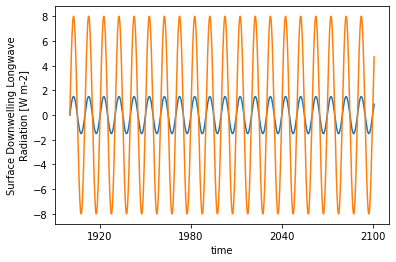

In [4]:
# Define start and end times (based on "experiment" calendar, see https://github.com/COSIMA/access-om2/wiki/Tutorials#Scaling-the-forcing-fields)
tstart = 1900 # start year of window in which scaling will be applied (1900 = initial time of control simulation)
tend = 2100 # end year of window in which scaling will be applied

seconds_in_year = (cftime.DatetimeNoLeap(1901,1,1,0,0,0,0) - cftime.DatetimeNoLeap(1900,1,1,0,0,0,0)).total_seconds()

# Define sinusoid properties:
Tamp = 1.5  # degrees C
LRamp = 8   # Wm-2
period = 10 # years
zeroYR = 0  # years

# Extract time series and structure from original files:
Tds_in = xr.open_dataset(Tin)
LRds_in = xr.open_dataset(LRin)

timeRYF = Tds_in.time.values
timeFULL = np.concatenate(np.array([np.array([cftime.DatetimeNoLeap(year,x.month,x.day,x.hour,0,0,0) for x in timeRYF]) for year in np.arange(tstart,tend+1)])).ravel()
timeYR = np.array([(x-cftime.DatetimeNoLeap(1900,1,1,0,0,0,0)).total_seconds()/seconds_in_year for x in timeFULL])

# Make sinusoids:
tas_ts = Tamp*np.sin(2*np.pi*(timeYR-zeroYR)/period)
rlds_ts = LRamp*np.sin(2*np.pi*(timeYR-zeroYR)/period)

# Create new Datasets:
tas = xr.DataArray(tas_ts, dims=['time'], coords={'time': timeFULL}, attrs=Tds_in.tas.attrs)
Tds_out = Tds_in.drop_vars('tas').assign_coords({'time':timeFULL})
Tds_out['tas'] = tas
Tds_out.attrs.update({'title': 'Scaling for ' + Tds_out.attrs['title']})


rlds = xr.DataArray(rlds_ts, dims=['time'], coords={'time': timeFULL}, attrs=LRds_in.rlds.attrs)
LRds_out = LRds_in.drop_vars('rlds').assign_coords({'time':timeFULL})
LRds_out['rlds'] = rlds
LRds_out.attrs.update({'title': 'Scaling for ' + LRds_out.attrs['title']})

# Plot as check:
Tds_out.tas.plot()
LRds_out.rlds.plot()

# Convert time back to days since 1900-1-1 (this is clunky... I'm sure there's a better way):
Tds_out = Tds_out.assign_coords({'time':timeYR*seconds_in_year/86400})
LRds_out = LRds_out.assign_coords({'time':timeYR*seconds_in_year/86400})
attrsdic = {
    'long_name':      "time",
    'units':          "days since 1900-01-01",
    'cartesian_axis': "T",
    'calendar_type':  "NOLEAP",
    'calendar':       "NOLEAP"}
Tds_out.time.attrs = attrsdic
LRds_out.time.attrs = attrsdic

# Save back to netcdf:
LRds_out.to_netcdf(LRout)
Tds_out.to_netcdf(Tout)

In [13]:
Tds_out

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 320, lon: 640, time: 586920)
Coordinates:
  * time      (time) float64 0.0 0.125 0.25 ... 7.336e+04 7.336e+04 7.336e+04
  * lat       (lat) float64 -89.57 -89.01 -88.45 -87.89 ... 88.45 89.01 89.57
  * lon       (lon) float64 0.0 0.5625 1.125 1.688 ... 357.8 358.3 358.9 359.4
    height    float64 10.0
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds) float64 -90.0 -89.29 -89.29 ... 89.29 89.29 90.0
    lon_bnds  (lon, bnds) float64 -0.2812 0.2812 0.2812 ... 359.2 359.2 359.7
    tas       (time) float64 0.0 0.0003228 0.0006455 ... 0.8809 0.8812 0.8814
Attributes:
    Conventions:         CF-1.7 CMIP-6.2
    activity_id:         input4MIPs
    cell_measures:       area: areacella
    comment:             Based on JRA-55 reanalysis (1958-01 to 2019-01)
    contact:             Hiroyuki Tsujino (htsujino@mri-jma.go.jp)
    creation_date:       2019-03-07T23:02:50Z
    data_specs_version:  01.00.29
    dataset_category:    atmosphericState
    external_variables:  areacella
    frequency:           3hrPt
    further_info_url:    http://climate.mri-jma.go.jp/~htsujino/jra55do.html
    grid:                data regridded to the normal atmosphere TL319 gaussi...
    grid_label:          gr
    history:             2019-03-07T23:02:50Z; CMOR rewrote data to be consis...
    institution:         Meteorological Research Institute, Tsukuba, Ibaraki ...
    institution_id:      MRI
    mip_era:             CMIP6
    nominal_resolution:  50 km
    product:             reanalysis
    realm:               atmos
    references:          Tsujino et al., 2018: JRA-55 based surface dataset f...
    region:              global_ocean
    release_year:        2019
    source:              MRI JRA55-do 1.4.0: Atmospheric state generated for ...
    source_description:  Atmospheric state and terrestrial runoff datasets pr...
    source_id:           MRI-JRA55-do-1-4-0
    source_type:         satellite_blended
    source_version:      1.4.0
    table_id:            input4MIPs_A3hrPt
    table_info:          Creation Date:(06 March 2019) MD5:b14ca57e92343d575b...
    target_mip:          OMIP
    title:               Scaling for MRI JRA55-do 1.4.0 dataset prepared for ...
    tracking_id:         hdl:21.14100/497c8675-ee02-48d6-9f2f-ea9738d3dcb8
    variable_id:         tas
    license:             OMIP boundary condition data produced by MRI is lice...
    cmor_version:        3.4.0